In [1]:
model_name = 'lightgbm'
device = 'cpu'
min_samples_per_class = 5
n_classes = 3
n_frac = 0.005
n_trials_tpe = 10
plot_param_importances = False
timeout_tpe = 60
random_state = 42
n_jobs = -1

In [2]:
# Parameters
model_name = "xgboostrf"
device = "cpu"
min_samples_per_class = 5
n_classes = 34
n_frac = 0.05
n_trials_tpe = 1000
plot_param_importances = False
timeout_tpe = 3600
random_state = 42
n_jobs = -1


In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# UTILS

In [4]:
def stratified_sample_df(df, stratify_col, frac, min_samples_per_class, random_state):
    grouped = df.groupby(stratify_col)
    sample = grouped.apply(
        lambda x: x.sample(
            n=max(min_samples_per_class, int(len(x) * frac)), 
            replace=len(x) < max(min_samples_per_class, int(len(x) * frac)),
            random_state=random_state
        )
    ).reset_index(drop=True)
    return sample

In [5]:
def build_classifier(extra_kwargs={}):
    clf = None
    if model_name in ['lgbm', 'lightgbm']:
        import lightgbm as lgb
        kwargs = {
            'device_type': device,
            'n_jobs': n_jobs,
            'objective': 'binary' if n_classes == 2 else 'multiclass',
            'random_state': random_state,
            'verbose': 1,
            **extra_kwargs
        }
        if n_classes > 2:
            kwargs['num_class'] = n_classes
        clf = lgb.LGBMClassifier(**kwargs)
    elif model_name in ['xgb', 'xgboost']:
        from xgboost import XGBClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBClassifier(**kwargs)
    elif model_name in ['xgbrf', 'xgboostrf']:
        from xgboost import XGBRFClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBRFClassifier(**kwargs)
    return clf

In [6]:
from collections import OrderedDict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def process_metrics(y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results = OrderedDict({
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'Recall (Weighted)': recall_weighted,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
        'F1 (Weighted)': f1_weighted
    })

    pprint(results, indent=4)

In [7]:
from sklearn.metrics import classification_report

def process_classification_report(y_test, y_pred):
    try:
        cr = classification_report(y_test, y_pred, digits=6, target_names=labels)
        print(cr)
    except Exception as e:
        print('Cloud not build/show classification report. Reason:', e)

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def process_confusion_matrix(y_test, y_pred):
    try:
        y_test_decoded = [index_to_label[label] for label in y_test]
        y_pred_decoded = [index_to_label[label] for label in y_pred]
        cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)
        cm = np.round(cm / 1000, 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(values_format='g')
    except Exception as e:
        print('Cloud not build/show confusion matrix. Reason:', e)

In [9]:
import numpy as np

def value_counts_to_dict(array):
    unique, counts = np.unique(array, return_counts=True)
    value_counts_dict = dict(zip(unique, counts))
    return value_counts_dict

# STEP 1: DATA PREP

In [10]:
# %load_ext cudf.pandas
import numpy as np
import pandas as pd
from pprint import pprint

if n_classes == 3: # dummy dataset
    df_sample = pd.read_parquet('input/dummy.parquet')
else:
    df_sample = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_sample['label'], unique_values = df_sample['label'].factorize()

label_to_index = {value: i for i, value in enumerate(unique_values)}
index_to_label = {v: k for k, v in label_to_index.items()}
labels = list(label_to_index.keys())
pprint(label_to_index, indent=4)

{   'Backdoor_Malware': 28,
    'BenignTraffic': 12,
    'BrowserHijacking': 29,
    'CommandInjection': 25,
    'DDoS-ACK_Fragmentation': 14,
    'DDoS-HTTP_Flood': 23,
    'DDoS-ICMP_Flood': 2,
    'DDoS-ICMP_Fragmentation': 17,
    'DDoS-PSHACK_Flood': 9,
    'DDoS-RSTFINFlood': 0,
    'DDoS-SYN_Flood': 8,
    'DDoS-SlowLoris': 27,
    'DDoS-SynonymousIP_Flood': 6,
    'DDoS-TCP_Flood': 10,
    'DDoS-UDP_Flood': 11,
    'DDoS-UDP_Fragmentation': 20,
    'DNS_Spoofing': 19,
    'DictionaryBruteForce': 30,
    'DoS-HTTP_Flood': 16,
    'DoS-SYN_Flood': 4,
    'DoS-TCP_Flood': 1,
    'DoS-UDP_Flood': 3,
    'MITM-ArpSpoofing': 13,
    'Mirai-greeth_flood': 5,
    'Mirai-greip_flood': 15,
    'Mirai-udpplain': 7,
    'Recon-HostDiscovery': 24,
    'Recon-OSScan': 21,
    'Recon-PingSweep': 32,
    'Recon-PortScan': 18,
    'SqlInjection': 31,
    'Uploading_Attack': 33,
    'VulnerabilityScan': 26,
    'XSS': 22}


In [11]:
# not stratified df sampling (just to check)
df_sample['label'].sample(frac=n_frac, random_state=random_state).value_counts()

label
2     359651
11    270509
10    224944
9     204524
8     202766
0     202569
6     179626
3     165461
1     133859
4     101355
12     54907
5      49814
7      44645
15     37673
17     22740
13     15515
20     14336
14     14311
19      8886
24      6838
21      5004
18      4219
16      3710
26      1839
23      1459
27      1201
30       625
29       298
25       271
31       239
22       179
28       167
32       118
33        71
Name: count, dtype: int64

In [12]:
# stratified df sampling
df_sample = stratified_sample_df(df_sample, 'label', n_frac, min_samples_per_class, random_state)

/tmp/ipykernel_3096323/2006267505.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = grouped.apply(


In [13]:
df_sample['label'].value_counts()

label
2     360025
11    270614
10    224883
9     204737
8     202959
0     202264
6     179906
3     165929
1     133572
4     101441
12     54909
5      49593
7      44528
15     37584
17     22624
13     15379
20     14346
14     14255
19      8945
24      6718
21      4912
18      4114
16      3593
26      1869
23      1439
27      1171
30       653
29       292
25       270
31       262
22       192
28       160
32       113
33        62
Name: count, dtype: int64

In [14]:
X_sample = df_sample.drop('label', axis=1)

print(type(X_sample))
print(X_sample.shape)
print(X_sample.dtypes)

<class 'pandas.core.frame.DataFrame'>
(2334313, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Max

In [15]:
y_sample = df_sample['label']

print(type(y_sample))
print(y_sample.shape)
print(y_sample.dtype)
print(y_sample.unique())
print(y_sample.nunique())
y_sample.value_counts()

<class 'pandas.core.series.Series'>
(2334313,)
int64
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
34


label
2     360025
11    270614
10    224883
9     204737
8     202959
0     202264
6     179906
3     165929
1     133572
4     101441
12     54909
5      49593
7      44528
15     37584
17     22624
13     15379
20     14346
14     14255
19      8945
24      6718
21      4912
18      4114
16      3593
26      1869
23      1439
27      1171
30       653
29       292
25       270
31       262
22       192
28       160
32       113
33        62
Name: count, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

# Split into 80% training+validation and 20% test
X_sample_train_val, X_sample_test, y_sample_train_val, y_sample_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=random_state, stratify=y_sample
)

# Split the 80% training+validation set into 75% training and 25% validation
X_sample_train, X_sample_val, y_sample_train, y_sample_val = train_test_split(
    X_sample_train_val, y_sample_train_val, test_size=0.25, random_state=random_state, stratify=y_sample_train_val
)

# Verify the sizes of the splits
print(f'Training   : {len(X_sample_train)}\t({(100.0 * len(X_sample_train) / len(X_sample)):.2f}) %\t{sorted(y_sample_train.unique())}')
print(f'Validation : {len(X_sample_val)}\t({(100.0 * len(X_sample_val) / len(X_sample)):.2f}) %\t{sorted(y_sample_val.unique())}')
print(f'Test       : {len(X_sample_test)}\t({(100.0 * len(X_sample_test) / len(X_sample)):.2f}) %\t{sorted(y_sample_test.unique())}')

Training   : 1400587	(60.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Validation : 466863	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Test       : 466863	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [17]:
assert sorted(y_sample_train.unique()) == sorted(y_sample_val.unique())
assert sorted(y_sample_train.unique()) == sorted(y_sample_test.unique())
assert sorted(y_sample_val.unique()) == sorted(y_sample_test.unique())

# STEP 2: PREPROCESSING & FEATURE SELECTION

### Preprocessing Methods

In [18]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler, StandardScaler

class DummyPreprocessor:
    def fit(self, _X, _y=None):
        return self
    def transform(self, _X):
        return _X

def make_preprocessor(pp_method):
    preprocessor = None
    if pp_method == 'none':
        preprocessor = DummyPreprocessor()
    if pp_method == 'maxabs':
        preprocessor = MaxAbsScaler()
    elif pp_method == 'minmax':
        preprocessor = MinMaxScaler()
    elif pp_method == 'norm':
        preprocessor = Normalizer()
    elif pp_method == 'robust':
        preprocessor = RobustScaler()
    elif pp_method == 'standard':
        preprocessor = StandardScaler()
    return preprocessor

### Feature Selection Methods

In [19]:
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA

class DummyFeatureSelector:
    def fit(self, _X, _y, _eval_set=None):
        self.support_ = np.ones(_X.shape[1], dtype=bool)
        return self
    def transform(self, _X):
        return _X[:, self.support_]

def make_feature_selector(fs_method, fs_metric):
    feature_selector = None
    if fs_method == 'none':
        feature_selector = DummyFeatureSelector()
    elif fs_method == 'boruta':
        feature_selector = BoostBoruta(build_classifier(), importance_type=fs_metric, perc=100, sampling_seed=random_state)
    elif fs_method == 'rfa':
        feature_selector = BoostRFA(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    elif fs_method == 'rfe':
        feature_selector = BoostRFE(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    return feature_selector

### HPO

In [20]:
%%time

import optuna

from optuna.samplers import GridSampler

def objective(trial):

    try:
        # preprocessing hyperparameters
        pp_method = trial.suggest_categorical('pp_method', ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'])

        # feature selection hyperparameters
        fs_method = trial.suggest_categorical('fs_method', ['none', 'boruta', 'rfa', 'rfe'])
        fs_metric = trial.suggest_categorical('fs_metric', ['feature_importances', 'shap_importances'])
        
        # pipeline - preprocessing
        preprocessor = make_preprocessor(pp_method)
        preprocessor.fit(X_sample_train)
        X_sample_train_prep = pd.DataFrame(preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
        X_sample_val_prep = pd.DataFrame(preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
        X_sample_test_prep = pd.DataFrame(preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)
    
        # pipeline - feature selection
        feature_selector = make_feature_selector(fs_method, fs_metric)
        feature_selector.fit(X_sample_train_prep, y_sample_train, eval_set=[(X_sample_val_prep, y_sample_val)])
        selected_features = X_sample_train_prep.columns[feature_selector.support_]
        trial.set_user_attr('selected_features', selected_features)
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_prep[selected_features], y_sample_train)
        y_sample_pred = model.predict(X_sample_test_prep[selected_features])
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'pp_method': ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'],
    'fs_method': ['boruta', 'rfa', 'rfe'],
    'fs_metric': ['feature_importances', 'shap_importances']
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-07-18 19:18:14,204] A new study created in memory with name: no-name-267c881e-ca08-4770-a272-c14324d1efef


[I 2024-07-18 19:36:25,048] Trial 0 pruned. 


index 33 is out of bounds for axis 0 with size 12


[I 2024-07-18 19:54:34,230] Trial 1 pruned. 


index 33 is out of bounds for axis 0 with size 12


[I 2024-07-18 20:14:52,429] Trial 2 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-18 23:02:55,444] Trial 3 finished with value: 0.705268364771003 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 3 with value: 0.705268364771003.


[I 2024-07-19 00:18:07,672] Trial 4 finished with value: 0.7082999856849369 and parameters: {'pp_method': 'standard', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7082999856849369.


[I 2024-07-19 00:36:28,646] Trial 5 pruned. 


index 33 is out of bounds for axis 0 with size 12


[I 2024-07-19 01:57:53,754] Trial 6 finished with value: 0.70505133483027 and parameters: {'pp_method': 'minmax', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7082999856849369.


[I 2024-07-19 02:16:05,243] Trial 7 pruned. 


index 33 is out of bounds for axis 0 with size 12


[I 2024-07-19 03:46:48,313] Trial 8 finished with value: 0.7086200186334866 and parameters: {'pp_method': 'standard', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 8 with value: 0.7086200186334866.


[I 2024-07-19 05:17:41,312] Trial 9 finished with value: 0.7087857857469464 and parameters: {'pp_method': 'robust', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 9 with value: 0.7087857857469464.


[I 2024-07-19 06:38:50,230] Trial 10 finished with value: 0.7054258066562791 and parameters: {'pp_method': 'maxabs', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 9 with value: 0.7087857857469464.


[I 2024-07-19 09:26:58,847] Trial 11 finished with value: 0.7052715267599666 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 9 with value: 0.7087857857469464.


[I 2024-07-19 12:17:59,508] Trial 12 finished with value: 0.738885857322674 and parameters: {'pp_method': 'norm', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 12 with value: 0.738885857322674.


[I 2024-07-19 12:38:10,078] Trial 13 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-19 12:58:18,580] Trial 14 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-19 15:46:06,591] Trial 15 finished with value: 0.6998984304003031 and parameters: {'pp_method': 'standard', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 12 with value: 0.738885857322674.


[I 2024-07-19 16:06:58,153] Trial 16 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-19 17:37:35,892] Trial 17 finished with value: 0.7045811819730688 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 12 with value: 0.738885857322674.


[I 2024-07-19 17:47:56,079] Trial 18 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-19 18:06:11,847] Trial 19 pruned. 


index 33 is out of bounds for axis 0 with size 12


[I 2024-07-19 18:30:05,059] Trial 20 finished with value: 0.7422526538157491 and parameters: {'pp_method': 'norm', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 20 with value: 0.7422526538157491.


[I 2024-07-19 18:40:34,232] Trial 21 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-19 20:08:58,486] Trial 22 finished with value: 0.741629503640377 and parameters: {'pp_method': 'norm', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 20 with value: 0.7422526538157491.


[I 2024-07-19 20:29:01,200] Trial 23 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-19 20:47:57,352] Trial 24 pruned. 


index 33 is out of bounds for axis 0 with size 12


[I 2024-07-19 22:03:16,755] Trial 25 finished with value: 0.7089449172499783 and parameters: {'pp_method': 'robust', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 20 with value: 0.7422526538157491.


[I 2024-07-19 22:23:16,352] Trial 26 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-19 23:47:17,953] Trial 27 finished with value: 0.70505133483027 and parameters: {'pp_method': 'none', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 20 with value: 0.7422526538157491.


[I 2024-07-19 23:57:41,866] Trial 28 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-20 02:46:09,504] Trial 29 finished with value: 0.7052715267599666 and parameters: {'pp_method': 'none', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 20 with value: 0.7422526538157491.


[I 2024-07-20 02:56:33,337] Trial 30 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-20 05:45:20,725] Trial 31 finished with value: 0.7007608467233264 and parameters: {'pp_method': 'robust', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 20 with value: 0.7422526538157491.


[I 2024-07-20 05:55:44,850] Trial 32 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-20 07:26:39,594] Trial 33 finished with value: 0.7045811819730688 and parameters: {'pp_method': 'none', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 20 with value: 0.7422526538157491.


[I 2024-07-20 08:57:21,396] Trial 34 finished with value: 0.7049760451670776 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 20 with value: 0.7422526538157491.


[I 2024-07-20 09:07:35,177] Trial 35 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)
CPU times: user 40d 5h 22min 6s, sys: 1h 27min 37s, total: 40d 6h 49min 43s
Wall time: 1d 13h 49min 21s


In [21]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0       NaN 2024-07-18 19:18:14.205159 2024-07-18 19:36:25.048395   
1        1       NaN 2024-07-18 19:36:25.049399 2024-07-18 19:54:34.230587   
2        2       NaN 2024-07-18 19:54:34.231378 2024-07-18 20:14:52.429398   
3        3  0.705268 2024-07-18 20:14:52.430152 2024-07-18 23:02:55.444725   
4        4  0.708300 2024-07-18 23:02:55.445765 2024-07-19 00:18:07.672755   
5        5       NaN 2024-07-19 00:18:07.673698 2024-07-19 00:36:28.646310   
6        6  0.705051 2024-07-19 00:36:28.647306 2024-07-19 01:57:53.754393   
7        7       NaN 2024-07-19 01:57:53.755437 2024-07-19 02:16:05.243876   
8        8  0.708620 2024-07-19 02:16:05.244705 2024-07-19 03:46:48.313103   
9        9  0.708786 2024-07-19 03:46:48.314171 2024-07-19 05:17:41.312216   
10      10  0.705426 2024-07-19 05:17:41.313028 2024-07-19 06:38:50.230319   
11      11  0.705272 2024-07-19 06:38:50.231183 2024-07-19 09:26:58.847326   
12      12  0.738886 2024-07-19 09:26:58.848295 2024-07-19 12:17:59.507830   
13      13       NaN 2024-07-19 12:17:59.508828 2024-07-19 12:38:10.078397   
14      14       NaN 2024-07-19 12:38:10.079288 2024-07-19 12:58:18.580291   
15      15  0.699898 2024-07-19 12:58:18.580965 2024-07-19 15:46:06.591335   
16      16       NaN 2024-07-19 15:46:06.592400 2024-07-19 16:06:58.153214   
17      17  0.704581 2024-07-19 16:06:58.153863 2024-07-19 17:37:35.892221   
18      18       NaN 2024-07-19 17:37:35.892873 2024-07-19 17:47:56.079716   
19      19       NaN 2024-07-19 17:47:56.080515 2024-07-19 18:06:11.847113   
20      20  0.742253 2024-07-19 18:06:11.847914 2024-07-19 18:30:05.059241   
21      21       NaN 2024-07-19 18:30:05.060184 2024-07-19 18:40:34.232662   
22      22  0.741630 2024-07-19 18:40:34.233572 2024-07-19 20:08:58.486532   
23      23       NaN 2024-07-19 20:08:58.487562 2024-07-19 20:29:01.200272   
24      24       NaN 2024-07-19 20:29:01.201021 2024-07-19 20:47:57.352284   
25      25  0.708945 2024-07-19 20:47:57.353172 2024-07-19 22:03:16.755645   
26      26       NaN 2024-07-19 22:03:16.756701 2024-07-19 22:23:16.351945   
27      27  0.705051 2024-07-19 22:23:16.352737 2024-07-19 23:47:17.953228   
28      28       NaN 2024-07-19 23:47:17.954223 2024-07-19 23:57:41.866639   
29      29  0.705272 2024-07-19 23:57:41.867395 2024-07-20 02:46:09.504418   
30      30       NaN 2024-07-20 02:46:09.505353 2024-07-20 02:56:33.337903   
31      31  0.700761 2024-07-20 02:56:33.338622 2024-07-20 05:45:20.725391   
32      32       NaN 2024-07-20 05:45:20.726251 2024-07-20 05:55:44.849947   
33      33  0.704581 2024-07-20 05:55:44.850674 2024-07-20 07:26:39.594487   
34      34  0.704976 2024-07-20 07:26:39.595546 2024-07-20 08:57:21.396117   
35      35       NaN 2024-07-20 08:57:21.397149 2024-07-20 09:07:35.177560   

                 duration params_fs_method     params_fs_metric  \
0  0 days 00:18:10.843236              rfe     shap_importances   
1  0 days 00:18:09.181188              rfe     shap_importances   
2  0 days 00:20:18.198020              rfa     shap_importances   
3  0 days 02:48:03.014573              rfa  feature_importances   
4  0 days 01:15:12.226990           boruta  feature_importances   
5  0 days 00:18:20.972612              rfe     shap_importances   
6  0 days 01:21:25.107087           boruta  feature_importances   
7  0 days 00:18:11.488439              rfe     shap_importances   
8  0 days 01:30:43.068398              rfe  feature_importances   
9  0 days 01:30:52.998045              rfe  feature_importances   
10 0 days 01:21:08.917291           boruta  feature_importances   
11 0 days 02:48:08.616143              rfa  feature_importances   
12 0 days 02:51:00.659535              rfa  feature_importances   
13 0 days 00:20:10.569569              rfa     shap_importances   
14 0 days 00:20:08.501003              rfa     shap_importances   
15 0 days 02:47:48.010370              rfa  f

In [22]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [23]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [24]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [25]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

[W 2024-07-20 09:07:36,885] Param fs_metric unique value length is less than 2.


[W 2024-07-20 09:07:36,886] Param fs_metric unique value length is less than 2.


[W 2024-07-20 09:07:36,886] Param fs_metric unique value length is less than 2.


[W 2024-07-20 09:07:36,886] Param fs_metric unique value length is less than 2.


In [26]:
best_preprocessor = make_preprocessor(study.best_trial.params['pp_method'])
best_preprocessor.fit(X_sample_train)
X_sample_train = pd.DataFrame(best_preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
X_sample_val = pd.DataFrame(best_preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
X_sample_test = pd.DataFrame(best_preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)

best_selected_features = study.best_trial.user_attrs['selected_features']
X_sample_train = X_sample_train[best_selected_features]
X_sample_val = X_sample_val[best_selected_features]
X_sample_test = X_sample_test[best_selected_features]

# STEP 3: DATA BALANCING

### Oversampling

In [27]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.over_sampling import *

def build_oversampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_generate = {
            class_: perfectly_balanced_occurences - occ
                    if occ < perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_generate = {
            class_: int(min(occ * threshold, perfectly_balanced_occurences - occ))
            if occ < perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_generate

def patch_oversampling_strategy(value_counts, n_generate):
    return {k : (value_counts[k] + n_generate[k]) for k in value_counts.keys()}

def make_over_sampler(over_strategy):
    over_sampler = RandomOverSampler(
        random_state=random_state, sampling_strategy=over_strategy)
    return over_sampler

### Undersampling

In [28]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.under_sampling import *

def build_undersampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_remove = {
            class_: occ - perfectly_balanced_occurences
                    if occ > perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_remove = {
            class_: int(min(occ * threshold, occ - perfectly_balanced_occurences))
            if occ > perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_remove

def patch_undersampling_strategy(value_counts, n_remove):
    return {k : (value_counts[k] - n_remove[k]) for k in value_counts.keys()}

def make_under_sampler(under_strategy):
    under_sampler = RandomUnderSampler(
        random_state=random_state, sampling_strategy=under_strategy)
    return under_sampler

### Combination

In [29]:
def fit_resample(_X_train, _y_train, over_thresh, under_thresh):

    _X_names = _X_train.columns.tolist()
    _y_name = _y_train.name
    
    _X_train_copy = _X_train.copy()
    _y_train_copy = _y_train.copy()

    if over_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_generate = build_oversampling_strategy(value_counts, over_thresh)
        over_strategy = patch_oversampling_strategy(value_counts, n_generate)
        over_sampler = make_over_sampler(over_strategy)
        _X_train_copy, _y_train_copy = over_sampler.fit_resample(_X_train_copy, _y_train_copy)

    if under_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_remove = build_undersampling_strategy(value_counts, under_thresh)
        under_strategy = patch_undersampling_strategy(value_counts, n_remove)
        under_sampler = make_under_sampler(under_strategy)
        _X_train_copy, _y_train_copy = under_sampler.fit_resample(_X_train_copy, _y_train_copy)

    return pd.DataFrame(_X_train_copy, columns=_X_names), pd.Series(_y_train_copy, name=_y_name)

### HPO

In [30]:
from itertools import chain

over_threshold_choices = list(chain(*[np.linspace(0, 4, num=17).round(2), ['auto']]))
under_threshold_choices = list(chain(*[np.linspace(0, 0.95, num=20).round(2), ['auto']]))

In [31]:
%%time
def objective(trial):

    try:
        # data balancing hyperparameters
        over_threshold = trial.suggest_categorical('over_threshold', over_threshold_choices)
        under_threshold = trial.suggest_categorical('under_threshold', under_threshold_choices)
    
        # pipeline - data balancing
        X_sample_train_bal, y_sample_train_bal = fit_resample(
            X_sample_train, y_sample_train, over_threshold, under_threshold
        )
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_bal, y_sample_train_bal)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)

    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'over_threshold': over_threshold_choices,
    'under_threshold': under_threshold_choices
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-07-20 09:07:38,291] A new study created in memory with name: no-name-7d29ce97-f65d-4e4b-b654-f05428db4bde


[I 2024-07-20 09:08:53,747] Trial 0 finished with value: 0.7806469483945593 and parameters: {'over_threshold': 3.75, 'under_threshold': 'auto'}. Best is trial 0 with value: 0.7806469483945593.


[I 2024-07-20 09:11:02,265] Trial 1 finished with value: 0.7855680964233278 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.0}. Best is trial 1 with value: 0.7855680964233278.


[I 2024-07-20 09:13:00,999] Trial 2 finished with value: 0.7692185349482429 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.0}. Best is trial 1 with value: 0.7855680964233278.


[I 2024-07-20 09:14:15,544] Trial 3 finished with value: 0.8014444145676445 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.75}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:16:06,019] Trial 4 finished with value: 0.7873659364445655 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.1}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:17:54,209] Trial 5 finished with value: 0.7809090855615416 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.15}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:19:10,289] Trial 6 finished with value: 0.7935858880281006 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.95}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:20:32,687] Trial 7 finished with value: 0.7588438383386817 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.25}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:22:45,632] Trial 8 finished with value: 0.7527210452444928 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.8}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:24:28,766] Trial 9 finished with value: 0.7926629526942769 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.2}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:25:43,695] Trial 10 finished with value: 0.7720237057207319 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.45}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:27:07,715] Trial 11 finished with value: 0.7981400979116877 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.4}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:28:13,103] Trial 12 finished with value: 0.7885387857480323 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.85}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:29:47,025] Trial 13 finished with value: 0.7768080126941925 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.25}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:30:43,133] Trial 14 finished with value: 0.7688332289867543 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.7}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:32:01,402] Trial 15 finished with value: 0.7633562719174203 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.45}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:33:27,996] Trial 16 finished with value: 0.7751665029589833 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.45}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:34:16,844] Trial 17 finished with value: 0.7479199369945746 and parameters: {'over_threshold': 0.0, 'under_threshold': 'auto'}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:35:18,228] Trial 18 finished with value: 0.7700247063477257 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.9}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:36:24,405] Trial 19 finished with value: 0.7889381381399945 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.65}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:37:41,311] Trial 20 finished with value: 0.7738144929661812 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.45}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:38:36,289] Trial 21 finished with value: 0.7764769823273444 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.75}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:40:01,296] Trial 22 finished with value: 0.7537777020488262 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.3}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:41:18,109] Trial 23 finished with value: 0.7626441746395335 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.35}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:42:15,377] Trial 24 finished with value: 0.7624674797191959 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.95}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:44:24,147] Trial 25 finished with value: 0.7527210452444928 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.7}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:45:37,274] Trial 26 finished with value: 0.8008722194477841 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.85}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:46:46,342] Trial 27 finished with value: 0.78144656684419 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.9}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:48:22,239] Trial 28 finished with value: 0.7344523664774243 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.1}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:50:17,497] Trial 29 finished with value: 0.7959656217148815 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.1}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:51:27,953] Trial 30 finished with value: 0.7911050420101505 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.8}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:53:03,394] Trial 31 finished with value: 0.7883271155738918 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.25}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:54:02,734] Trial 32 finished with value: 0.7636766972236049 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.85}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:55:41,529] Trial 33 finished with value: 0.7921452823054038 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.35}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:57:16,278] Trial 34 finished with value: 0.7910584770790613 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.25}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 09:59:22,815] Trial 35 finished with value: 0.7500731100978134 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.6}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:01:10,647] Trial 36 finished with value: 0.7438825837252624 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.1}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:02:28,274] Trial 37 finished with value: 0.7741083473810332 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.45}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:03:40,342] Trial 38 finished with value: 0.7876814831679378 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.65}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:04:49,022] Trial 39 finished with value: 0.7901734105833961 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.8}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:06:11,218] Trial 40 finished with value: 0.7676509447102495 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.35}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:07:09,132] Trial 41 finished with value: 0.7624674797191959 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.85}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:08:30,843] Trial 42 finished with value: 0.7812210073138245 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.55}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:10:28,292] Trial 43 finished with value: 0.7700450449318537 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.0}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:12:07,484] Trial 44 finished with value: 0.7495816172078489 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.15}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:13:11,017] Trial 45 finished with value: 0.7734284774763728 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.6}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:14:43,655] Trial 46 finished with value: 0.7873914437991892 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.3}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:16:21,720] Trial 47 finished with value: 0.7804716923346289 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.15}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:17:32,662] Trial 48 finished with value: 0.7786951010030095 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.65}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:19:01,481] Trial 49 finished with value: 0.7651892445795636 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.25}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:20:07,583] Trial 50 finished with value: 0.7885387857480323 and parameters: {'over_threshold': 1.5, 'under_threshold': 'auto'}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:21:33,078] Trial 51 finished with value: 0.7766863873596099 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.45}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:22:39,900] Trial 52 finished with value: 0.7681669138170659 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.6}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:23:41,000] Trial 53 finished with value: 0.7760603087335279 and parameters: {'over_threshold': 0.75, 'under_threshold': 'auto'}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:25:44,917] Trial 54 finished with value: 0.7721563526046467 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.0}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:27:31,939] Trial 55 finished with value: 0.7656916107734054 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.1}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:28:49,392] Trial 56 finished with value: 0.7796119502090976 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.7}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:30:19,962] Trial 57 finished with value: 0.7889700629915094 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.4}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:31:51,147] Trial 58 finished with value: 0.7606045612323108 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.25}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:33:10,904] Trial 59 finished with value: 0.7816181069187101 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.6}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:34:26,661] Trial 60 finished with value: 0.7806469483945593 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.8}. Best is trial 3 with value: 0.8014444145676445.


[I 2024-07-20 10:35:45,504] Trial 61 finished with value: 0.8069603766387187 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.65}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:37:01,308] Trial 62 finished with value: 0.7806469483945593 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.9}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:38:18,952] Trial 63 finished with value: 0.7557287886597386 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.4}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:39:28,640] Trial 64 finished with value: 0.7694022402542169 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.65}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:41:19,401] Trial 65 finished with value: 0.7758592822256067 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.1}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:42:16,568] Trial 66 finished with value: 0.7624674797191959 and parameters: {'over_threshold': 0.25, 'under_threshold': 'auto'}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:43:22,898] Trial 67 finished with value: 0.790589556768353 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.95}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:45:26,131] Trial 68 finished with value: 0.7599753227641092 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.0}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:46:27,258] Trial 69 finished with value: 0.7760603087335279 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.95}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:48:37,967] Trial 70 finished with value: 0.7481619970944702 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.55}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:49:47,977] Trial 71 finished with value: 0.7613497945966236 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.5}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:51:12,864] Trial 72 finished with value: 0.7743736232487634 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.35}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:52:24,308] Trial 73 finished with value: 0.7911050420101505 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.9}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:53:36,545] Trial 74 finished with value: 0.7788846224180108 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.85}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:54:54,895] Trial 75 finished with value: 0.7640345534124368 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.3}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:56:10,576] Trial 76 finished with value: 0.7806469483945593 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.85}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:57:18,319] Trial 77 finished with value: 0.8037450447122111 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.95}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 10:58:55,402] Trial 78 finished with value: 0.7774380462909667 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.2}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:00:10,174] Trial 79 finished with value: 0.7941328062452023 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.8}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:02:05,849] Trial 80 finished with value: 0.7633589400853287 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.0}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:03:22,535] Trial 81 finished with value: 0.7806469483945593 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.95}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:04:26,357] Trial 82 finished with value: 0.7679634863724403 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.7}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:06:02,600] Trial 83 finished with value: 0.7802841323693507 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.35}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:07:18,266] Trial 84 finished with value: 0.7849592330001509 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.6}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:08:43,150] Trial 85 finished with value: 0.7868702207281925 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.4}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:10:33,295] Trial 86 finished with value: 0.7675379556602229 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.05}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:12:41,627] Trial 87 finished with value: 0.7492392143111275 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.65}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:14:18,820] Trial 88 finished with value: 0.7593408251243707 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.2}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:15:13,829] Trial 89 finished with value: 0.7674281351505551 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.65}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:16:40,277] Trial 90 finished with value: 0.7806450742894046 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.4}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:17:54,008] Trial 91 finished with value: 0.8008722194477841 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.95}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:19:48,122] Trial 92 finished with value: 0.7834409739144784 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.05}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:20:58,156] Trial 93 finished with value: 0.7903353605790712 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.75}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:22:30,523] Trial 94 finished with value: 0.764185438493026 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.35}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:24:40,275] Trial 95 finished with value: 0.7527210452444928 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.95}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:25:43,262] Trial 96 finished with value: 0.7680108351767875 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.8}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:27:31,049] Trial 97 finished with value: 0.7549827017350074 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.05}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:28:38,656] Trial 98 finished with value: 0.7874220012188813 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.7}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:30:35,465] Trial 99 finished with value: 0.7904975853539604 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.1}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:32:22,452] Trial 100 finished with value: 0.7932605837042912 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.2}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:33:35,797] Trial 101 finished with value: 0.8008722194477841 and parameters: {'over_threshold': 3.25, 'under_threshold': 'auto'}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:35:24,734] Trial 102 finished with value: 0.7731128092625417 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.05}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:37:26,675] Trial 103 finished with value: 0.7769644247972367 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.05}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:39:18,444] Trial 104 finished with value: 0.7729378115270601 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.1}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:40:49,082] Trial 105 finished with value: 0.7928726656646058 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.5}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:42:13,752] Trial 106 finished with value: 0.8015848215013837 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.5}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:43:23,509] Trial 107 finished with value: 0.78144656684419 and parameters: {'over_threshold': 2.5, 'under_threshold': 'auto'}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:45:04,192] Trial 108 finished with value: 0.765477217555277 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.1}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:46:19,548] Trial 109 finished with value: 0.7655241558669784 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.4}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:47:36,920] Trial 110 finished with value: 0.7851474760261423 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.55}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:49:02,942] Trial 111 finished with value: 0.7304256021217584 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.2}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:50:48,529] Trial 112 finished with value: 0.7758933334296642 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.2}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:52:53,797] Trial 113 finished with value: 0.7916363124251857 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.0}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:54:24,627] Trial 114 finished with value: 0.7602621356895465 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.2}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:55:35,930] Trial 115 finished with value: 0.7533577653714593 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.4}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:57:33,893] Trial 116 finished with value: 0.7799041796217726 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.05}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 11:58:42,737] Trial 117 finished with value: 0.7901734105833961 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.95}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:01:00,370] Trial 118 finished with value: 0.7892343726014791 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.25}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:06:03,781] Trial 119 finished with value: 0.7456525769103717 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.05}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:07:39,700] Trial 120 finished with value: 0.772101989547491 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.2}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:08:42,080] Trial 121 finished with value: 0.7680108351767875 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.9}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:10:17,221] Trial 122 finished with value: 0.7725454097099901 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.3}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:11:22,253] Trial 123 finished with value: 0.772092977377762 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.55}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:12:40,058] Trial 124 finished with value: 0.7995174294161751 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.65}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:14:18,682] Trial 125 finished with value: 0.741437333065767 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.05}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:15:39,199] Trial 126 finished with value: 0.7735949342993914 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.4}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:16:49,696] Trial 127 finished with value: 0.7870045552552941 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.6}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:18:28,384] Trial 128 finished with value: 0.774623459781551 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.3}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:20:51,524] Trial 129 finished with value: 0.7485745328724922 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.2}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:22:18,041] Trial 130 finished with value: 0.7844771249019158 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.4}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:24:02,985] Trial 131 finished with value: 0.7721821907312956 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.15}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:25:49,993] Trial 132 finished with value: 0.7769189998038539 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.15}. Best is trial 61 with value: 0.8069603766387187.


[I 2024-07-20 12:27:03,195] Trial 133 finished with value: 0.8112966971793929 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.75}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:28:01,405] Trial 134 finished with value: 0.7636766972236049 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.9}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:29:16,583] Trial 135 finished with value: 0.7664850270710348 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.5}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:31:18,300] Trial 136 finished with value: 0.7703272040173322 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.0}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:32:28,244] Trial 137 finished with value: 0.7901734105833961 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.9}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:33:20,137] Trial 138 finished with value: 0.7750130798709884 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.7}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:35:00,727] Trial 139 finished with value: 0.7675643915768235 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.25}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:36:46,719] Trial 140 finished with value: 0.7854189462780613 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.2}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:39:13,664] Trial 141 finished with value: 0.7535420262340258 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.1}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:40:41,545] Trial 142 finished with value: 0.7901052906520912 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.4}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:42:06,385] Trial 143 finished with value: 0.7558321763457123 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.3}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:43:20,960] Trial 144 finished with value: 0.8001139930142875 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.65}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:44:27,125] Trial 145 finished with value: 0.7885387857480323 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.8}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:45:57,367] Trial 146 finished with value: 0.7285434388176361 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.2}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:47:09,044] Trial 147 finished with value: 0.7874241941396615 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.5}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:48:38,927] Trial 148 finished with value: 0.8023895811896482 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.4}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:49:45,383] Trial 149 finished with value: 0.790589556768353 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.8}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:51:23,197] Trial 150 finished with value: 0.8062037725928298 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.3}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:52:35,413] Trial 151 finished with value: 0.7788846224180108 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.8}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:53:52,329] Trial 152 finished with value: 0.7798361841783102 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.5}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:55:20,598] Trial 153 finished with value: 0.7625582342512596 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.35}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:56:19,976] Trial 154 finished with value: 0.7624674797191959 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.9}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:57:20,175] Trial 155 finished with value: 0.7760603087335279 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.9}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 12:59:13,084] Trial 156 finished with value: 0.7653001966079107 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.0}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:00:19,848] Trial 157 finished with value: 0.7684098180968866 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.65}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:01:26,279] Trial 158 finished with value: 0.790589556768353 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.9}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:02:38,438] Trial 159 finished with value: 0.7638937077852352 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.45}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:03:45,089] Trial 160 finished with value: 0.7690523889658865 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.6}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:04:56,282] Trial 161 finished with value: 0.7816424630351263 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.55}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:06:10,092] Trial 162 finished with value: 0.7788846224180108 and parameters: {'over_threshold': 3.0, 'under_threshold': 'auto'}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:07:11,372] Trial 163 finished with value: 0.7700247063477257 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.8}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:08:28,043] Trial 164 finished with value: 0.7935858880281006 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.9}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:09:26,289] Trial 165 finished with value: 0.7689267466676565 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.6}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:11:09,799] Trial 166 finished with value: 0.7827760265827123 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.25}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:12:18,838] Trial 167 finished with value: 0.78144656684419 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.85}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:13:25,257] Trial 168 finished with value: 0.790589556768353 and parameters: {'over_threshold': 1.75, 'under_threshold': 'auto'}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:14:23,762] Trial 169 finished with value: 0.7636766972236049 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.95}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:15:34,519] Trial 170 finished with value: 0.7911050420101505 and parameters: {'over_threshold': 2.75, 'under_threshold': 'auto'}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:16:42,196] Trial 171 finished with value: 0.7748949132227735 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.55}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:18:16,968] Trial 172 finished with value: 0.7812112373088607 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.3}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:19:25,845] Trial 173 finished with value: 0.772633752936452 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.6}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:21:39,018] Trial 174 finished with value: 0.7468140661955164 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.4}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:23:30,382] Trial 175 finished with value: 0.7850108477252972 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.25}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:24:44,958] Trial 176 finished with value: 0.7891080601994556 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.7}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:25:33,840] Trial 177 finished with value: 0.7479199369945746 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.95}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:27:28,841] Trial 178 finished with value: 0.788079708292804 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.1}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:28:55,258] Trial 179 finished with value: 0.7582323047543089 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.25}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:30:08,106] Trial 180 finished with value: 0.7788846224180108 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.95}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:31:10,144] Trial 181 finished with value: 0.7680108351767875 and parameters: {'over_threshold': 1.25, 'under_threshold': 'auto'}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:32:54,737] Trial 182 finished with value: 0.7456425866311418 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.05}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:34:17,512] Trial 183 finished with value: 0.8047267025630878 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.55}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:36:29,289] Trial 184 finished with value: 0.7542974400280837 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.45}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:37:49,886] Trial 185 finished with value: 0.8023503421165099 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.55}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:39:11,435] Trial 186 finished with value: 0.7816662711046131 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.5}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:40:49,930] Trial 187 finished with value: 0.7658694264335089 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.15}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:41:58,860] Trial 188 finished with value: 0.78144656684419 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.8}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:43:49,246] Trial 189 finished with value: 0.7791975284769065 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.05}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:45:46,123] Trial 190 finished with value: 0.8000637725870705 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.1}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:47:40,057] Trial 191 finished with value: 0.78880210533773 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.05}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:48:52,780] Trial 192 finished with value: 0.7929353817867255 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.7}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:49:53,832] Trial 193 finished with value: 0.7667361892124188 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.7}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:51:15,264] Trial 194 finished with value: 0.7831054196535104 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.45}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:52:18,549] Trial 195 finished with value: 0.7607314982739192 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.5}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:53:30,950] Trial 196 finished with value: 0.7876589108277873 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.6}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:55:26,958] Trial 197 finished with value: 0.7826733902811532 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.15}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:57:26,709] Trial 198 finished with value: 0.7864849461588415 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.05}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 13:58:54,989] Trial 199 finished with value: 0.7983658999513996 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.45}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:00:32,373] Trial 200 finished with value: 0.7657348061122236 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.15}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:02:06,313] Trial 201 finished with value: 0.7827353816598288 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.3}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:03:46,234] Trial 202 finished with value: 0.7691120006484011 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.3}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:05:17,072] Trial 203 finished with value: 0.7845273657037442 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.45}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:06:15,200] Trial 204 finished with value: 0.7636766972236049 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.8}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:07:32,581] Trial 205 finished with value: 0.8077142209923464 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.7}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:08:48,649] Trial 206 finished with value: 0.7989227390340811 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.75}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:10:11,565] Trial 207 finished with value: 0.7940657577556937 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.45}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:11:35,250] Trial 208 finished with value: 0.7657516825198187 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.35}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:13:22,297] Trial 209 finished with value: 0.778051000094466 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.15}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:14:40,671] Trial 210 finished with value: 0.8006106432291134 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.6}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:16:08,070] Trial 211 finished with value: 0.78259808933195 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.3}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:18:15,194] Trial 212 finished with value: 0.7766275123666271 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.0}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:19:51,794] Trial 213 finished with value: 0.7740151458196882 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.2}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:21:42,669] Trial 214 finished with value: 0.7726728876686598 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.05}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:23:05,739] Trial 215 finished with value: 0.776977021305148 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.35}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:24:07,256] Trial 216 finished with value: 0.7700247063477257 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.85}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:25:22,459] Trial 217 finished with value: 0.7941328062452023 and parameters: {'over_threshold': 3.5, 'under_threshold': 'auto'}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:27:12,551] Trial 218 finished with value: 0.7886055557799693 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.15}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:28:46,044] Trial 219 finished with value: 0.7840155528623847 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.3}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:30:00,384] Trial 220 finished with value: 0.7941328062452023 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.95}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:31:27,394] Trial 221 finished with value: 0.7744785418006455 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.3}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:32:27,050] Trial 222 finished with value: 0.7800488768973987 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.75}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:33:16,329] Trial 223 finished with value: 0.7479199369945746 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.85}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:34:25,620] Trial 224 finished with value: 0.7842134464549446 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.55}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:35:38,353] Trial 225 finished with value: 0.7911050420101505 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.95}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:36:52,340] Trial 226 finished with value: 0.8008722194477841 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.8}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:38:00,172] Trial 227 finished with value: 0.8037450447122111 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.9}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:40:10,134] Trial 228 finished with value: 0.7564060496553763 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.5}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:42:17,601] Trial 229 finished with value: 0.7917211688574433 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.0}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:43:29,760] Trial 230 finished with value: 0.7934837946650974 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.65}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:44:50,974] Trial 231 finished with value: 0.7839458324727854 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.45}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:46:09,424] Trial 232 finished with value: 0.7966051342409244 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.6}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:47:41,880] Trial 233 finished with value: 0.7865386924196552 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.35}. Best is trial 133 with value: 0.8112966971793929.


[I 2024-07-20 14:48:52,891] Trial 234 finished with value: 0.8136783526118408 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.75}. Best is trial 234 with value: 0.8136783526118408.


[I 2024-07-20 14:50:01,131] Trial 235 finished with value: 0.7901734105833961 and parameters: {'over_threshold': 2.25, 'under_threshold': 'auto'}. Best is trial 234 with value: 0.8136783526118408.


[I 2024-07-20 14:51:03,657] Trial 236 finished with value: 0.7700247063477257 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.95}. Best is trial 234 with value: 0.8136783526118408.


[I 2024-07-20 14:52:55,967] Trial 237 finished with value: 0.7785261924495818 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.1}. Best is trial 234 with value: 0.8136783526118408.


[I 2024-07-20 14:54:02,500] Trial 238 finished with value: 0.790589556768353 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.85}. Best is trial 234 with value: 0.8136783526118408.


[I 2024-07-20 14:55:15,944] Trial 239 finished with value: 0.8008722194477841 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.9}. Best is trial 234 with value: 0.8136783526118408.


[I 2024-07-20 14:56:25,951] Trial 240 finished with value: 0.7866872698763608 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.75}. Best is trial 234 with value: 0.8136783526118408.


[I 2024-07-20 14:58:01,115] Trial 241 finished with value: 0.8138620876325366 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.4}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 14:59:18,075] Trial 242 finished with value: 0.7935858880281006 and parameters: {'over_threshold': 4.0, 'under_threshold': 'auto'}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:00:22,566] Trial 243 finished with value: 0.7801742541405422 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.7}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:01:23,789] Trial 244 finished with value: 0.7700247063477257 and parameters: {'over_threshold': 1.0, 'under_threshold': 'auto'}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:03:16,519] Trial 245 finished with value: 0.7841022252921113 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.05}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:04:32,065] Trial 246 finished with value: 0.7965816865850651 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.6}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:06:18,682] Trial 247 finished with value: 0.7815163875309944 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.15}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:07:47,554] Trial 248 finished with value: 0.792099069469145 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.3}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:08:53,676] Trial 249 finished with value: 0.7885387857480323 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.95}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:11:03,849] Trial 250 finished with value: 0.7527210452444928 and parameters: {'over_threshold': 'auto', 'under_threshold': 'auto'}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:12:11,002] Trial 251 finished with value: 0.7530766039736082 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.45}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:13:17,055] Trial 252 finished with value: 0.7840870249554847 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.7}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:14:24,253] Trial 253 finished with value: 0.8037450447122111 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.8}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:15:34,084] Trial 254 finished with value: 0.7885867396419893 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.55}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:16:45,405] Trial 255 finished with value: 0.7911050420101505 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.85}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:18:01,356] Trial 256 finished with value: 0.7935858880281006 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.85}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:19:11,978] Trial 257 finished with value: 0.7991946882579917 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.7}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:20:34,647] Trial 258 finished with value: 0.7895948178431872 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.5}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:21:50,764] Trial 259 finished with value: 0.7935858880281006 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.8}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:23:41,584] Trial 260 finished with value: 0.7665138971755423 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.1}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:25:37,034] Trial 261 finished with value: 0.7885393615922276 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.05}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:27:34,179] Trial 262 finished with value: 0.7763801668652911 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.05}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:29:21,398] Trial 263 finished with value: 0.7652754354839947 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.15}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:30:22,412] Trial 264 finished with value: 0.7674704683426697 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.65}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:31:52,891] Trial 265 finished with value: 0.7936986813991576 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.45}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:33:19,475] Trial 266 finished with value: 0.7859272876253227 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.4}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:34:34,395] Trial 267 finished with value: 0.7941328062452023 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.85}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:35:23,692] Trial 268 finished with value: 0.7664948657500413 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.8}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:37:14,932] Trial 269 finished with value: 0.7906239572798369 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.15}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:38:31,027] Trial 270 finished with value: 0.7673544681378427 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.55}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:40:40,002] Trial 271 finished with value: 0.7527210452444928 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.85}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:41:50,570] Trial 272 finished with value: 0.7848066272917031 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.75}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:43:24,087] Trial 273 finished with value: 0.796249963222849 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.35}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:44:44,775] Trial 274 finished with value: 0.7960064421911384 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.55}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:46:21,830] Trial 275 finished with value: 0.771561770801698 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.25}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:48:25,070] Trial 276 finished with value: 0.7914087127901114 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.0}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:49:24,089] Trial 277 finished with value: 0.7573257470266859 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.65}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:50:26,693] Trial 278 finished with value: 0.7680108351767875 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.95}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:51:26,921] Trial 279 finished with value: 0.7760603087335279 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.85}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:53:09,467] Trial 280 finished with value: 0.7755671244485564 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.25}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:54:24,120] Trial 281 finished with value: 0.7941328062452023 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.9}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:55:29,770] Trial 282 finished with value: 0.7633910591859199 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.6}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:57:11,318] Trial 283 finished with value: 0.7863148772155354 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.3}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 15:58:58,128] Trial 284 finished with value: 0.7831146220448412 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.1}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:00:24,242] Trial 285 finished with value: 0.7993237267297557 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.5}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:02:21,053] Trial 286 finished with value: 0.781437732976868 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.0}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:03:40,780] Trial 287 finished with value: 0.7863873190030688 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.6}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:05:14,971] Trial 288 finished with value: 0.7758248771577236 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.4}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:06:29,307] Trial 289 finished with value: 0.7802643158141772 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.5}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:08:22,638] Trial 290 finished with value: 0.7401275283231079 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.0}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:09:32,157] Trial 291 finished with value: 0.78144656684419 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.95}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:11:50,814] Trial 292 finished with value: 0.7534387106098249 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.3}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:13:29,089] Trial 293 finished with value: 0.7737508691060171 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.3}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:15:08,915] Trial 294 finished with value: 0.764196113309311 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.2}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:16:15,083] Trial 295 finished with value: 0.7875175426223415 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.75}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:17:31,199] Trial 296 finished with value: 0.7791074709816247 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.5}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:18:57,061] Trial 297 finished with value: 0.7891958570263027 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.45}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:20:41,921] Trial 298 finished with value: 0.7802325270123953 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.2}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:21:48,749] Trial 299 finished with value: 0.7770838496458283 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.5}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:23:03,719] Trial 300 finished with value: 0.7813438246912007 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.7}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:24:44,465] Trial 301 finished with value: 0.7970326219955202 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.25}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:26:25,368] Trial 302 finished with value: 0.772878113191698 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.15}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:27:55,465] Trial 303 finished with value: 0.7913914926147899 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.4}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:29:04,378] Trial 304 finished with value: 0.7901734105833961 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.85}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:30:30,667] Trial 305 finished with value: 0.7685058234782857 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.35}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:31:54,861] Trial 306 finished with value: 0.7826563212707551 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.45}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:32:55,179] Trial 307 finished with value: 0.7620601107970483 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.55}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:34:42,233] Trial 308 finished with value: 0.7847837200787117 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.2}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:35:44,381] Trial 309 finished with value: 0.7680108351767875 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.85}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:36:42,314] Trial 310 finished with value: 0.7645105829017167 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.8}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:38:15,095] Trial 311 finished with value: 0.7834693365760884 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.35}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:39:54,324] Trial 312 finished with value: 0.7753779655102881 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.2}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:41:13,987] Trial 313 finished with value: 0.77789566334514 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.5}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:42:57,877] Trial 314 finished with value: 0.7973224009829016 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.2}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:44:39,304] Trial 315 finished with value: 0.7633011507242037 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.1}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:45:37,657] Trial 316 finished with value: 0.7636766972236049 and parameters: {'over_threshold': 0.5, 'under_threshold': 'auto'}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:46:56,301] Trial 317 finished with value: 0.7944803320071818 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.55}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:48:22,699] Trial 318 finished with value: 0.7671859129399351 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.35}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:49:31,787] Trial 319 finished with value: 0.7842963830315592 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.75}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:51:20,377] Trial 320 finished with value: 0.777260389902216 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.1}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:53:35,874] Trial 321 finished with value: 0.748766831381505 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.35}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:54:49,728] Trial 322 finished with value: 0.7951307285021484 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.55}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:55:50,423] Trial 323 finished with value: 0.7760603087335279 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.8}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 16:58:14,304] Trial 324 finished with value: 0.749103097491039 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.25}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:00:23,387] Trial 325 finished with value: 0.7527210452444928 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.9}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:01:26,808] Trial 326 finished with value: 0.7787306552033774 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.65}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:02:43,226] Trial 327 finished with value: 0.7806531140649849 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.45}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:04:00,350] Trial 328 finished with value: 0.8010836050942114 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.65}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:05:05,932] Trial 329 finished with value: 0.7885387857480323 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.9}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:06:55,720] Trial 330 finished with value: 0.7829563620146751 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.1}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:08:26,163] Trial 331 finished with value: 0.7486479958813375 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.15}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:09:39,239] Trial 332 finished with value: 0.7934792028453004 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.6}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:11:25,527] Trial 333 finished with value: 0.7667244507111449 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.25}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:12:47,162] Trial 334 finished with value: 0.7865165852426036 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.55}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:13:47,385] Trial 335 finished with value: 0.7658352815426417 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.75}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:15:30,450] Trial 336 finished with value: 0.7406162827420741 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.05}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:17:09,227] Trial 337 finished with value: 0.7716547438019936 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.15}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:19:35,912] Trial 338 finished with value: 0.7490804166070388 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.15}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:21:40,504] Trial 339 finished with value: 0.7825892507626109 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.0}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:22:48,804] Trial 340 finished with value: 0.8037450447122111 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.85}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:24:49,566] Trial 341 finished with value: 0.7667222904428941 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.0}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:25:58,477] Trial 342 finished with value: 0.7748270878640421 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.7}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:27:48,162] Trial 343 finished with value: 0.7718046783201363 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.05}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:29:31,121] Trial 344 finished with value: 0.77567962746418 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.2}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:30:35,594] Trial 345 finished with value: 0.7731511850924242 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.65}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:31:26,700] Trial 346 finished with value: 0.7648867133256817 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.75}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:34:05,427] Trial 347 finished with value: 0.7451017777133228 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.0}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:35:39,296] Trial 348 finished with value: 0.7842035472480211 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.25}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:36:28,635] Trial 349 finished with value: 0.7479199369945746 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.9}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:37:29,094] Trial 350 finished with value: 0.7690795391813835 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.7}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:38:58,509] Trial 351 finished with value: 0.7677099997864744 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.35}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:40:33,475] Trial 352 finished with value: 0.7962738892129526 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.35}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:42:00,164] Trial 353 finished with value: 0.7809094506444448 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.4}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:43:12,261] Trial 354 finished with value: 0.7844119425980124 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.75}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:45:01,933] Trial 355 finished with value: 0.7845892143916029 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.15}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:46:52,029] Trial 356 finished with value: 0.7422526538157491 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.0}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:48:11,985] Trial 357 finished with value: 0.7948458542479567 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.5}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:49:19,938] Trial 358 finished with value: 0.8037450447122111 and parameters: {'over_threshold': 2.0, 'under_threshold': 'auto'}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:50:32,918] Trial 359 finished with value: 0.7788846224180108 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.9}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:52:09,816] Trial 360 finished with value: 0.772771472005497 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.25}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:53:34,138] Trial 361 finished with value: 0.7700349269669603 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.4}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:54:41,044] Trial 362 finished with value: 0.7977186197121277 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.75}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:56:13,538] Trial 363 finished with value: 0.7818746837714914 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.35}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:57:29,888] Trial 364 finished with value: 0.8017199982174438 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.65}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 17:58:48,242] Trial 365 finished with value: 0.7828992570769547 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.5}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 18:00:00,954] Trial 366 finished with value: 0.7927045446657234 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.7}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 18:01:40,467] Trial 367 finished with value: 0.7810163965258257 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.3}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 18:02:49,155] Trial 368 finished with value: 0.794211628111569 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.75}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 18:04:06,060] Trial 369 finished with value: 0.7817281899399535 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.55}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 18:05:18,115] Trial 370 finished with value: 0.7875903291998751 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.55}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 18:06:33,451] Trial 371 finished with value: 0.7973931742684089 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.7}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 18:07:48,641] Trial 372 finished with value: 0.7793590033097969 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.65}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 18:09:57,711] Trial 373 finished with value: 0.7527210452444928 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.75}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 18:11:14,900] Trial 374 finished with value: 0.8125548109881526 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.75}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 18:12:22,925] Trial 375 finished with value: 0.7839799743396819 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.6}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 18:13:37,224] Trial 376 finished with value: 0.7813397788449578 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.6}. Best is trial 241 with value: 0.8138620876325366.


[I 2024-07-20 18:15:03,089] Trial 377 finished with value: 0.7779948723283913 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.5}. Best is trial 241 with value: 0.8138620876325366.


CPU times: user 10d 22h 9min 59s, sys: 29min 15s, total: 10d 22h 39min 14s
Wall time: 9h 7min 24s


In [32]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0         0  0.780647 2024-07-20 09:07:38.292381 2024-07-20 09:08:53.747760   
1         1  0.785568 2024-07-20 09:08:53.748825 2024-07-20 09:11:02.265151   
2         2  0.769219 2024-07-20 09:11:02.266204 2024-07-20 09:13:00.999543   
3         3  0.801444 2024-07-20 09:13:01.000286 2024-07-20 09:14:15.544217   
4         4  0.787366 2024-07-20 09:14:15.545240 2024-07-20 09:16:06.019515   
..      ...       ...                        ...                        ...   
373     373  0.752721 2024-07-20 18:07:48.642369 2024-07-20 18:09:57.710893   
374     374  0.812555 2024-07-20 18:09:57.711795 2024-07-20 18:11:14.900656   
375     375  0.783980 2024-07-20 18:11:14.901705 2024-07-20 18:12:22.924912   
376     376  0.781340 2024-07-20 18:12:22.925914 2024-07-20 18:13:37.224660   
377     377  0.777995 2024-07-20 18:13:37.225684 2024-07-20 18:15:03.088853   

                  duration params_over_threshold params_under_threshold  \
0   0 days 00:01:15.455379                  3.75                   auto   
1   0 days 00:02:08.516326                   4.0                    0.0   
2   0 days 00:01:58.733339                  1.75                    0.0   
3   0 days 00:01:14.543931                   3.5                   0.75   
4   0 days 00:01:50.474275                  1.75                    0.1   
..                     ...                   ...                    ...   
373 0 days 00:02:09.068524                  auto                   0.75   
374 0 days 00:01:17.188861                   4.0                   0.75   
375 0 days 00:01:08.023207                  1.25                    0.6   
376 0 days 00:01:14.298746                   2.5                    0.6   
377 0 days 00:01:25.863169                  3.25                    0.5   

     system_attrs_grid_id                          system_attrs_search_space  \
0                       0  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
1                       1  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
2                       2  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
3                       3  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
4                       4  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
..                    ...                                                ...   
373                   373  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
374                   374  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
375                   375  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
376                   376  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
377                   377  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   

        state  
0    COMPLETE  
1    COMPLETE  
2    COMPLETE  
3    COMPLETE  
4    COMPLETE  
..        ...  
373  COMPLETE  
374  COMPLETE  
375  COMPLETE  
376  COMPLETE  
377  COMPLETE  

[378 rows x 10 columns]

In [33]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [34]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [35]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [36]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [37]:
best_over_threshold = study.best_trial.params['over_threshold']
best_under_threshold = study.best_trial.params['under_threshold']

X_sample_train, y_sample_train = fit_resample(
    X_sample_train, y_sample_train, best_over_threshold, best_under_threshold
)

# STEP 4: CLASSIFICATION

In [38]:
%%time
from optuna.samplers import TPESampler

# Configure HPO objetive function
def objective(trial):

    try:
        # pipeline - classifier hyperparameters
        if model_name in ['lgbm', 'lightgbm', 'xgb', 'xgboost']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
            }
        elif model_name in ['xgbrf', 'xgboostrf']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0)
        }

        # pipeline - classifier fit/predict
        model = build_classifier(hpo_kwargs)
        model.fit(X_sample_train, y_sample_train)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a TPE sampler
sampler = TPESampler()
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_tpe, timeout=timeout_tpe)

[I 2024-07-20 18:15:05,577] A new study created in memory with name: no-name-0077e982-c3b7-4ed1-983e-ad065d50e7bb


[I 2024-07-20 18:15:24,779] Trial 0 finished with value: 0.8186341507622922 and parameters: {'n_estimators': 20, 'max_depth': 13, 'learning_rate': 0.11787047685780545, 'subsample': 0.7068340035630879, 'colsample_bytree': 0.5620453392764322, 'reg_alpha': 0.18850035118698039, 'reg_lambda': 0.9816199503989185}. Best is trial 0 with value: 0.8186341507622922.


[I 2024-07-20 18:18:03,132] Trial 1 finished with value: 0.8248285387111912 and parameters: {'n_estimators': 171, 'max_depth': 9, 'learning_rate': 0.029675143300535813, 'subsample': 0.9549490299318477, 'colsample_bytree': 0.6589328675338423, 'reg_alpha': 0.5550538608453434, 'reg_lambda': 0.5001016973741335}. Best is trial 1 with value: 0.8248285387111912.


[I 2024-07-20 18:20:01,599] Trial 2 finished with value: 0.7536483486002967 and parameters: {'n_estimators': 138, 'max_depth': 4, 'learning_rate': 0.09843753382616963, 'subsample': 0.8219776412885813, 'colsample_bytree': 0.5138753238196068, 'reg_alpha': 0.7293216479164356, 'reg_lambda': 0.007673334797986375}. Best is trial 1 with value: 0.8248285387111912.


[I 2024-07-20 18:23:18,990] Trial 3 finished with value: 0.8257161249629857 and parameters: {'n_estimators': 198, 'max_depth': 20, 'learning_rate': 0.011465273968881669, 'subsample': 0.7410926001196136, 'colsample_bytree': 0.9470230198653364, 'reg_alpha': 0.43685267345178747, 'reg_lambda': 0.5853002764054676}. Best is trial 3 with value: 0.8257161249629857.


[I 2024-07-20 18:25:43,542] Trial 4 finished with value: 0.8236438353069335 and parameters: {'n_estimators': 153, 'max_depth': 19, 'learning_rate': 0.013816650464675095, 'subsample': 0.5136275326076848, 'colsample_bytree': 0.7021970149987327, 'reg_alpha': 0.8516977592608425, 'reg_lambda': 0.12175698353676356}. Best is trial 3 with value: 0.8257161249629857.


[I 2024-07-20 18:27:59,429] Trial 5 finished with value: 0.825778003612266 and parameters: {'n_estimators': 147, 'max_depth': 9, 'learning_rate': 0.2809342501163708, 'subsample': 0.6962066891206211, 'colsample_bytree': 0.524142225571276, 'reg_alpha': 0.7575248505364032, 'reg_lambda': 0.06827560053474035}. Best is trial 5 with value: 0.825778003612266.


[I 2024-07-20 18:29:54,206] Trial 6 finished with value: 0.8280491567886077 and parameters: {'n_estimators': 121, 'max_depth': 14, 'learning_rate': 0.01829967458350642, 'subsample': 0.9454924047526008, 'colsample_bytree': 0.6543002611323372, 'reg_alpha': 0.9819875585447616, 'reg_lambda': 0.1912417785717514}. Best is trial 6 with value: 0.8280491567886077.


[I 2024-07-20 18:31:57,562] Trial 7 finished with value: 0.8192804696604034 and parameters: {'n_estimators': 132, 'max_depth': 10, 'learning_rate': 0.05235436671451866, 'subsample': 0.8278610083950991, 'colsample_bytree': 0.5376136332252575, 'reg_alpha': 0.7356366872344895, 'reg_lambda': 0.9742233059299579}. Best is trial 6 with value: 0.8280491567886077.


[I 2024-07-20 18:33:08,544] Trial 8 finished with value: 0.8266075476655345 and parameters: {'n_estimators': 75, 'max_depth': 13, 'learning_rate': 0.15338412477604121, 'subsample': 0.9387782064045749, 'colsample_bytree': 0.602446723244225, 'reg_alpha': 0.7059371782088949, 'reg_lambda': 0.572794706229419}. Best is trial 6 with value: 0.8280491567886077.


[I 2024-07-20 18:34:11,233] Trial 9 finished with value: 0.8273657427086151 and parameters: {'n_estimators': 67, 'max_depth': 13, 'learning_rate': 0.20132060838339802, 'subsample': 0.6006180457035247, 'colsample_bytree': 0.9210943737361168, 'reg_alpha': 0.4005729982992349, 'reg_lambda': 0.2506046019476742}. Best is trial 6 with value: 0.8280491567886077.


[I 2024-07-20 18:35:41,149] Trial 10 finished with value: 0.8293426057351736 and parameters: {'n_estimators': 94, 'max_depth': 17, 'learning_rate': 0.22486998492787516, 'subsample': 0.8649300639858349, 'colsample_bytree': 0.7580210957068423, 'reg_alpha': 0.9789669324935556, 'reg_lambda': 0.3237069563061675}. Best is trial 10 with value: 0.8293426057351736.


[I 2024-07-20 18:37:12,567] Trial 11 finished with value: 0.8263722526490926 and parameters: {'n_estimators': 95, 'max_depth': 18, 'learning_rate': 0.23618188559271835, 'subsample': 0.8807513870271306, 'colsample_bytree': 0.8045507936147278, 'reg_alpha': 0.996520436811975, 'reg_lambda': 0.2783786990520689}. Best is trial 10 with value: 0.8293426057351736.


[I 2024-07-20 18:38:44,683] Trial 12 finished with value: 0.8285705500776684 and parameters: {'n_estimators': 105, 'max_depth': 16, 'learning_rate': 0.21290595372902635, 'subsample': 0.9989453780391443, 'colsample_bytree': 0.7929991797444569, 'reg_alpha': 0.9980649273002781, 'reg_lambda': 0.3177134466668813}. Best is trial 10 with value: 0.8293426057351736.


[I 2024-07-20 18:39:22,219] Trial 13 finished with value: 0.831725780065276 and parameters: {'n_estimators': 41, 'max_depth': 16, 'learning_rate': 0.20670377711073348, 'subsample': 0.9899599099476544, 'colsample_bytree': 0.8115247072737956, 'reg_alpha': 0.0529312333534081, 'reg_lambda': 0.3494099334280288}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:39:48,098] Trial 14 finished with value: 0.8269108430509553 and parameters: {'n_estimators': 26, 'max_depth': 16, 'learning_rate': 0.2889692949232553, 'subsample': 0.8558290935782588, 'colsample_bytree': 0.8461568875633008, 'reg_alpha': 0.05533396388427302, 'reg_lambda': 0.3889190153411138}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:40:35,009] Trial 15 finished with value: 0.8260222978399088 and parameters: {'n_estimators': 48, 'max_depth': 17, 'learning_rate': 0.17008794998620824, 'subsample': 0.8870292788712513, 'colsample_bytree': 0.8802462364532369, 'reg_alpha': 0.2673739101799649, 'reg_lambda': 0.6902703206296266}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:41:13,905] Trial 16 finished with value: 0.6460334017677719 and parameters: {'n_estimators': 48, 'max_depth': 2, 'learning_rate': 0.2510649777702107, 'subsample': 0.7826284798506772, 'colsample_bytree': 0.7437655783129209, 'reg_alpha': 0.053796828689940575, 'reg_lambda': 0.3986051043652266}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:42:24,031] Trial 17 finished with value: 0.8059532173043868 and parameters: {'n_estimators': 83, 'max_depth': 6, 'learning_rate': 0.1752090332923968, 'subsample': 0.993048361564004, 'colsample_bytree': 0.9995628863482483, 'reg_alpha': 0.5815284272007244, 'reg_lambda': 0.8006744378513553}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:43:12,728] Trial 18 finished with value: 0.8316929527889217 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.24644508475157417, 'subsample': 0.9070292095581745, 'colsample_bytree': 0.7605275792270303, 'reg_alpha': 0.30496409870138724, 'reg_lambda': 0.41947853332248214}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:43:23,071] Trial 19 finished with value: 0.8211856720555287 and parameters: {'n_estimators': 10, 'max_depth': 15, 'learning_rate': 0.25943858907970796, 'subsample': 0.9150432892940947, 'colsample_bytree': 0.8523295976358553, 'reg_alpha': 0.22301631506174405, 'reg_lambda': 0.4324768802172898}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:44:06,126] Trial 20 finished with value: 0.8236825217822608 and parameters: {'n_estimators': 46, 'max_depth': 11, 'learning_rate': 0.19126496810906957, 'subsample': 0.6192915402872448, 'colsample_bytree': 0.7168770363375769, 'reg_alpha': 0.326179653039041, 'reg_lambda': 0.5237432917543811}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:45:08,651] Trial 21 finished with value: 0.829096226527706 and parameters: {'n_estimators': 63, 'max_depth': 18, 'learning_rate': 0.22541131080082052, 'subsample': 0.9058893303561186, 'colsample_bytree': 0.7824957778812321, 'reg_alpha': 0.15575622041772746, 'reg_lambda': 0.3389042057538845}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:45:43,239] Trial 22 finished with value: 0.8261883820073114 and parameters: {'n_estimators': 35, 'max_depth': 15, 'learning_rate': 0.26236294287449696, 'subsample': 0.8165960226612918, 'colsample_bytree': 0.7485513289133805, 'reg_alpha': 0.001220851182984345, 'reg_lambda': 0.16485406169887096}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:47:05,857] Trial 23 finished with value: 0.8277815105079933 and parameters: {'n_estimators': 87, 'max_depth': 17, 'learning_rate': 0.14180385310374483, 'subsample': 0.9649882157050569, 'colsample_bytree': 0.8149055814930677, 'reg_alpha': 0.11851040255554735, 'reg_lambda': 0.6662883096515271}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:48:07,093] Trial 24 finished with value: 0.8253428787975539 and parameters: {'n_estimators': 62, 'max_depth': 20, 'learning_rate': 0.2238287459054295, 'subsample': 0.856067427655949, 'colsample_bytree': 0.6920783496862885, 'reg_alpha': 0.3684895297481019, 'reg_lambda': 0.440158000299468}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:49:57,671] Trial 25 finished with value: 0.8265928881375458 and parameters: {'n_estimators': 117, 'max_depth': 12, 'learning_rate': 0.19673917226343274, 'subsample': 0.9162171054656676, 'colsample_bytree': 0.7704092884907919, 'reg_alpha': 0.2878867551504491, 'reg_lambda': 0.23553713448604552}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:50:33,139] Trial 26 finished with value: 0.8260302204375769 and parameters: {'n_estimators': 37, 'max_depth': 15, 'learning_rate': 0.2986878759402045, 'subsample': 0.7718748584360772, 'colsample_bytree': 0.840182115191668, 'reg_alpha': 0.48395634988201175, 'reg_lambda': 0.33160648047112135}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:52:03,809] Trial 27 finished with value: 0.8258381623331326 and parameters: {'n_estimators': 99, 'max_depth': 18, 'learning_rate': 0.24438691259177991, 'subsample': 0.9825627453257065, 'colsample_bytree': 0.8887130730126361, 'reg_alpha': 0.5952814949786662, 'reg_lambda': 0.47822586402189876}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:52:57,823] Trial 28 finished with value: 0.8268787075612184 and parameters: {'n_estimators': 56, 'max_depth': 16, 'learning_rate': 0.2718724607956879, 'subsample': 0.8605340159315394, 'colsample_bytree': 0.6499860922858356, 'reg_alpha': 0.8689459075993232, 'reg_lambda': 0.3633130410805763}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:53:09,683] Trial 29 finished with value: 0.8247853980854343 and parameters: {'n_estimators': 11, 'max_depth': 13, 'learning_rate': 0.1270438514007401, 'subsample': 0.710976798959156, 'colsample_bytree': 0.6005586643908856, 'reg_alpha': 0.23011033425550553, 'reg_lambda': 0.6476030828665005}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:53:35,683] Trial 30 finished with value: 0.8294872171847876 and parameters: {'n_estimators': 27, 'max_depth': 14, 'learning_rate': 0.18213048914964933, 'subsample': 0.9260111289991224, 'colsample_bytree': 0.7293564136380009, 'reg_alpha': 0.1388879170622197, 'reg_lambda': 0.7630741636317147}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:53:57,833] Trial 31 finished with value: 0.824503392711752 and parameters: {'n_estimators': 23, 'max_depth': 14, 'learning_rate': 0.18085210685365696, 'subsample': 0.9384366767023979, 'colsample_bytree': 0.7290043336604218, 'reg_alpha': 0.13047796980548979, 'reg_lambda': 0.8134659550944219}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:54:27,713] Trial 32 finished with value: 0.8230105501128596 and parameters: {'n_estimators': 31, 'max_depth': 17, 'learning_rate': 0.21001200613386628, 'subsample': 0.962289248558275, 'colsample_bytree': 0.7594985802776398, 'reg_alpha': 0.18359159796643593, 'reg_lambda': 0.9530759120416692}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:55:08,551] Trial 33 finished with value: 0.8283037694537596 and parameters: {'n_estimators': 43, 'max_depth': 11, 'learning_rate': 0.2267285017729552, 'subsample': 0.9001778621047485, 'colsample_bytree': 0.6726440584526587, 'reg_alpha': 0.058938594197651115, 'reg_lambda': 0.8066251794756208}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:56:24,196] Trial 34 finished with value: 0.8271601541321978 and parameters: {'n_estimators': 77, 'max_depth': 14, 'learning_rate': 0.15550753216595642, 'subsample': 0.9304827490726675, 'colsample_bytree': 0.6172698734466732, 'reg_alpha': 0.011338969309279634, 'reg_lambda': 0.48956671616405134}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:56:45,761] Trial 35 finished with value: 0.8249408248314399 and parameters: {'n_estimators': 21, 'max_depth': 19, 'learning_rate': 0.09020428314448234, 'subsample': 0.8220606461789616, 'colsample_bytree': 0.8198373154585037, 'reg_alpha': 0.11797697012119503, 'reg_lambda': 0.572671629952586}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 18:59:30,902] Trial 36 finished with value: 0.8271295998164676 and parameters: {'n_estimators': 176, 'max_depth': 15, 'learning_rate': 0.18726404499907018, 'subsample': 0.9589560912173232, 'colsample_bytree': 0.6984848209438737, 'reg_alpha': 0.46419259620240355, 'reg_lambda': 0.7424380225100151}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 19:00:27,388] Trial 37 finished with value: 0.8281747056266203 and parameters: {'n_estimators': 60, 'max_depth': 12, 'learning_rate': 0.24387888889974202, 'subsample': 0.8629082896865823, 'colsample_bytree': 0.7297313637068394, 'reg_alpha': 0.5268508567769015, 'reg_lambda': 0.12523765083791327}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 19:01:35,696] Trial 38 finished with value: 0.8279436430192075 and parameters: {'n_estimators': 72, 'max_depth': 19, 'learning_rate': 0.10143873906097542, 'subsample': 0.9653297796241423, 'colsample_bytree': 0.7789061348273685, 'reg_alpha': 0.662463237877776, 'reg_lambda': 0.9089194102766679}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 19:03:16,444] Trial 39 finished with value: 0.8184593134090212 and parameters: {'n_estimators': 112, 'max_depth': 7, 'learning_rate': 0.20916106177155908, 'subsample': 0.8887944090034539, 'colsample_bytree': 0.8783308725089108, 'reg_alpha': 0.8339817500940739, 'reg_lambda': 0.2968054708558215}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 19:05:19,164] Trial 40 finished with value: 0.82823664368786 and parameters: {'n_estimators': 131, 'max_depth': 9, 'learning_rate': 0.16530794981728925, 'subsample': 0.8084081214302385, 'colsample_bytree': 0.8310017425876851, 'reg_alpha': 0.3331350991271508, 'reg_lambda': 0.03569851402577218}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 19:06:15,136] Trial 41 finished with value: 0.8289934904513487 and parameters: {'n_estimators': 56, 'max_depth': 18, 'learning_rate': 0.2219753330751658, 'subsample': 0.9072794224365287, 'colsample_bytree': 0.7774418882449592, 'reg_alpha': 0.18091135582078793, 'reg_lambda': 0.3484165913145868}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 19:07:43,672] Trial 42 finished with value: 0.8300211375262245 and parameters: {'n_estimators': 88, 'max_depth': 20, 'learning_rate': 0.23289154860093647, 'subsample': 0.9272125116894728, 'colsample_bytree': 0.8009317125975776, 'reg_alpha': 0.16465104762583727, 'reg_lambda': 0.4323198994018899}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 19:08:22,755] Trial 43 finished with value: 0.8287508448459296 and parameters: {'n_estimators': 38, 'max_depth': 20, 'learning_rate': 0.23361385996622355, 'subsample': 0.9387169752654815, 'colsample_bytree': 0.7996791511510126, 'reg_alpha': 0.08533655905216679, 'reg_lambda': 0.5314115206809457}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 19:09:42,972] Trial 44 finished with value: 0.8281604520148287 and parameters: {'n_estimators': 88, 'max_depth': 16, 'learning_rate': 0.26759371338217597, 'subsample': 0.9757376746424151, 'colsample_bytree': 0.7513563565353, 'reg_alpha': 0.2489365618765218, 'reg_lambda': 0.4332031089031063}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 19:11:25,367] Trial 45 finished with value: 0.829097595962188 and parameters: {'n_estimators': 103, 'max_depth': 19, 'learning_rate': 0.20885475686579563, 'subsample': 0.8381674098149345, 'colsample_bytree': 0.6840949537885744, 'reg_alpha': 0.19992640225098862, 'reg_lambda': 0.2323749371280447}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 19:13:45,615] Trial 46 finished with value: 0.827525301781391 and parameters: {'n_estimators': 145, 'max_depth': 17, 'learning_rate': 0.2798160878887044, 'subsample': 0.8760466251039327, 'colsample_bytree': 0.7203531565728232, 'reg_alpha': 0.42583588199314226, 'reg_lambda': 0.5964450572844382}. Best is trial 13 with value: 0.831725780065276.


[I 2024-07-20 19:15:17,067] Trial 47 finished with value: 0.8326774416638585 and parameters: {'n_estimators': 92, 'max_depth': 14, 'learning_rate': 0.2511010086328693, 'subsample': 0.9282096508980445, 'colsample_bytree': 0.8546571189643438, 'reg_alpha': 0.9278381595236249, 'reg_lambda': 0.27427046268681876}. Best is trial 47 with value: 0.8326774416638585.


CPU times: user 1d 8h 16min 35s, sys: 3min 12s, total: 1d 8h 19min 47s
Wall time: 1h 11s


In [39]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.818634 2024-07-20 18:15:05.579613 2024-07-20 18:15:24.779148   
1        1  0.824829 2024-07-20 18:15:24.780105 2024-07-20 18:18:03.132642   
2        2  0.753648 2024-07-20 18:18:03.133642 2024-07-20 18:20:01.599132   
3        3  0.825716 2024-07-20 18:20:01.599908 2024-07-20 18:23:18.990619   
4        4  0.823644 2024-07-20 18:23:18.991652 2024-07-20 18:25:43.542332   
5        5  0.825778 2024-07-20 18:25:43.543393 2024-07-20 18:27:59.429148   
6        6  0.828049 2024-07-20 18:27:59.429894 2024-07-20 18:29:54.206070   
7        7  0.819280 2024-07-20 18:29:54.206889 2024-07-20 18:31:57.561842   
8        8  0.826608 2024-07-20 18:31:57.562914 2024-07-20 18:33:08.544097   
9        9  0.827366 2024-07-20 18:33:08.544884 2024-07-20 18:34:11.233339   
10      10  0.829343 2024-07-20 18:34:11.234437 2024-07-20 18:35:41.149393   
11      11  0.826372 2024-07-20 18:35:41.150195 2024-07-20 18:37:12.566973   
12      12  0.828571 2024-07-20 18:37:12.567715 2024-07-20 18:38:44.683031   
13      13  0.831726 2024-07-20 18:38:44.683849 2024-07-20 18:39:22.219490   
14      14  0.826911 2024-07-20 18:39:22.220504 2024-07-20 18:39:48.097886   
15      15  0.826022 2024-07-20 18:39:48.098725 2024-07-20 18:40:35.009140   
16      16  0.646033 2024-07-20 18:40:35.010170 2024-07-20 18:41:13.905728   
17      17  0.805953 2024-07-20 18:41:13.906763 2024-07-20 18:42:24.031013   
18      18  0.831693 2024-07-20 18:42:24.032322 2024-07-20 18:43:12.728302   
19      19  0.821186 2024-07-20 18:43:12.729126 2024-07-20 18:43:23.071322   
20      20  0.823683 2024-07-20 18:43:23.072143 2024-07-20 18:44:06.126465   
21      21  0.829096 2024-07-20 18:44:06.127290 2024-07-20 18:45:08.651715   
22      22  0.826188 2024-07-20 18:45:08.652537 2024-07-20 18:45:43.238879   
23      23  0.827782 2024-07-20 18:45:43.239680 2024-07-20 18:47:05.857250   
24      24  0.825343 2024-07-20 18:47:05.858053 2024-07-20 18:48:07.093309   
25      25  0.826593 2024-07-20 18:48:07.094132 2024-07-20 18:49:57.671123   
26      26  0.826030 2024-07-20 18:49:57.672196 2024-07-20 18:50:33.139537   
27      27  0.825838 2024-07-20 18:50:33.140611 2024-07-20 18:52:03.809371   
28      28  0.826879 2024-07-20 18:52:03.810248 2024-07-20 18:52:57.822943   
29      29  0.824785 2024-07-20 18:52:57.824004 2024-07-20 18:53:09.683515   
30      30  0.829487 2024-07-20 18:53:09.684385 2024-07-20 18:53:35.683207   
31      31  0.824503 2024-07-20 18:53:35.684177 2024-07-20 18:53:57.832898   
32      32  0.823011 2024-07-20 18:53:57.833995 2024-07-20 18:54:27.713059   
33      33  0.828304 2024-07-20 18:54:27.713907 2024-07-20 18:55:08.551676   
34      34  0.827160 2024-07-20 18:55:08.552349 2024-07-20 18:56:24.196730   
35      35  0.824941 2024-07-20 18:56:24.197534 2024-07-20 18:56:45.761587   
36      36  0.827130 2024-07-20 18:56:45.762670 2024-07-20 18:59:30.901822   
37      37  0.828175 2024-07-20 18:59:30.902844 2024-07-20 19:00:27.388270   
38      38  0.827944 2024-07-20 19:00:27.389015 2024-07-20 19:01:35.696012   
39      39  0.818459 2024-07-20 19:01:35.696852 2024-07-20 19:03:16.444602   
40      40  0.828237 2024-07-20 19:03:16.445667 2024-07-20 19:05:19.164684   
41      41  0.828993 2024-07-20 19:05:19.165753 2024-07-20 19:06:15.136282   
42      42  0.830021 2024-07-20 19:06:15.137336 2024-07-20 19:07:43.672522   
43      43  0.828751 2024-07-20 19:07:43.673578 2024-07-20 19:08:22.754937   
44      44  0.828160 2024-07-20 19:08:22.755961 2024-07-20 19:09:42.972777   
45      45  0.829098 2024-07-20 19:09:42.973823 2024-07-20 19:11:25.367404   
46      46  0.827525 2024-07-20 19:11:25.368446 2024-07-20 19:13:45.615598   
47      47  0.832677 2024-07-20 19:13:45.616435 2024-07-20 19:15:17.067555   

                 duration  params_colsample_bytree  params_learning_rate  \
0  0 days 00:00:19.199535                 0.562045              0.117870   
1  0 days 00:02:38.352537    

In [40]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [41]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [42]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [43]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [44]:
best_model_params = study.best_trial.params

# STEP 5: EXTRAPOLATION & GENERALIZATION

In [45]:
if n_classes == 3: # dummy dataset
    df_full = pd.read_parquet('input/dummy.parquet')
else:
    df_full = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_full['label'].replace(to_replace=label_to_index, inplace=True)

In [46]:
X_full = df_full.drop('label', axis=1)

print(type(X_full))
print(X_full.shape)
print(X_full.dtypes)

<class 'pandas.core.frame.DataFrame'>
(46686579, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Ma

In [47]:
y_full = df_full['label']

print(type(y_full))
print(y_full.shape)
print(y_full.dtype)
print(y_full.nunique())

<class 'pandas.core.series.Series'>
(46686579,)
int64
34


In [48]:
# Split into 80% training and 20% test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=random_state, stratify=y_full
)

# Verify the sizes of the splits
print(f'Training   : {len(X_full_train)}\t({(100.0 * len(X_full_train) / len(X_full)):.2f}) %\t{sorted(y_full_train.unique())}')
print(f'Test       : {len(X_full_test)}\t({(100.0 * len(X_full_test) / len(X_full)):.2f}) %\t{sorted(y_full_test.unique())}')

Training   : 37349263	(80.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Test       : 9337316	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [49]:
assert sorted(y_full_train.unique()) == sorted(y_full_test.unique())

### Baseline

In [50]:
%%time
model = build_classifier()
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: user 9h 55min 9s, sys: 5min 55s, total: 10h 1min 4s
Wall time: 33min 53s


In [51]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9912310989582017),
                ('Precision (Macro)', 0.8579479089871773),
                ('Precision (Micro)', 0.9912310989582017),
                ('Precision (Weighted)', 0.990978551979319),
                ('Recall (Macro)', 0.7048862482096964),
                ('Recall (Micro)', 0.9912310989582017),
                ('Recall (Weighted)', 0.9912310989582017),
                ('F1 (Macro)', 0.7175268377610858),
                ('F1 (Micro)', 0.9912310989582017),
                ('F1 (Weighted)', 0.9902293697246715)])


In [52]:
process_classification_report(y_full_test, y_full_pred)

                         precision    recall  f1-score   support

       DDoS-RSTFINFlood   0.999937  0.999894  0.999915    809057
          DoS-TCP_Flood   0.999835  0.999156  0.999495    534289
        DDoS-ICMP_Flood   0.999978  0.999919  0.999949   1440101
          DoS-UDP_Flood   0.999962  0.998915  0.999438    663719
          DoS-SYN_Flood   0.998629  0.998351  0.998490    405767
     Mirai-greeth_flood   0.998595  0.995720  0.997155    198373
DDoS-SynonymousIP_Flood   0.999972  0.999116  0.999544    719628
         Mirai-udpplain   0.999108  0.999871  0.999489    178115
         DDoS-SYN_Flood   0.998913  0.999815  0.999364    811838
      DDoS-PSHACK_Flood   0.999863  0.999810  0.999836    818951
         DDoS-TCP_Flood   0.999520  0.999909  0.999714    899533
         DDoS-UDP_Flood   0.999267  0.999291  0.999279   1082457
          BenignTraffic   0.822270  0.975947  0.892542    219639
       MITM-ArpSpoofing   0.851871  0.732896  0.787917     61519
 DDoS-ACK_Fragmentation 

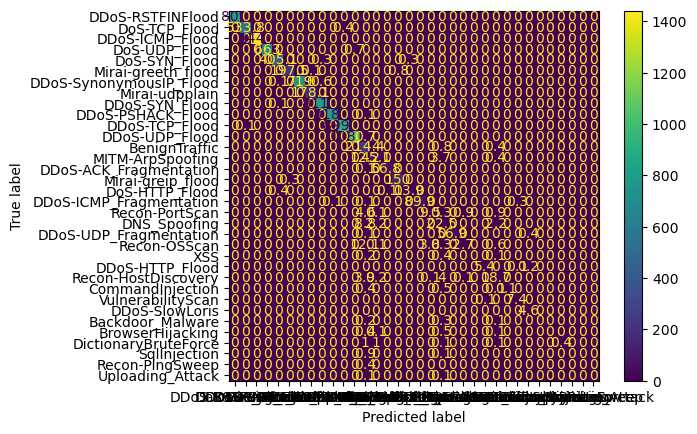

In [53]:
process_confusion_matrix(y_full_test, y_full_pred)

### Optimized

In [54]:
# redo preprocessing
best_preprocessor.fit(X_full_train)
X_full_train = pd.DataFrame(best_preprocessor.transform(X_full_train.copy()), columns=X_full_train.columns)
X_full_test = pd.DataFrame(best_preprocessor.transform(X_full_test.copy()), columns=X_full_test.columns)

# redo feature selection
X_full_train = X_full_train[best_selected_features]
X_full_test = X_full_test[best_selected_features]

# redo data balancing
X_full_train, y_full_train = fit_resample(
    X_full_train, y_full_train, best_over_threshold, best_under_threshold
)

# redo classifier building
model = build_classifier(best_model_params)

In [55]:
%%time
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: user 9h 6min 1s, sys: 4min 41s, total: 9h 10min 42s
Wall time: 25min 55s


In [56]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9945989832624279),
                ('Precision (Macro)', 0.8952958818992147),
                ('Precision (Micro)', 0.9945989832624279),
                ('Precision (Weighted)', 0.9946491737229727),
                ('Recall (Macro)', 0.8191654847698309),
                ('Recall (Micro)', 0.9945989832624279),
                ('Recall (Weighted)', 0.9945989832624279),
                ('F1 (Macro)', 0.8411351798475447),
                ('F1 (Micro)', 0.9945989832624279),
                ('F1 (Weighted)', 0.9945515411636944)])


In [57]:
process_classification_report(y_full_test, y_full_pred)

                         precision    recall  f1-score   support

       DDoS-RSTFINFlood   0.999991  0.999844  0.999918    809057
          DoS-TCP_Flood   0.999876  0.999289  0.999583    534289
        DDoS-ICMP_Flood   0.999965  0.999940  0.999952   1440101
          DoS-UDP_Flood   0.999756  0.999426  0.999591    663719
          DoS-SYN_Flood   0.999539  0.999177  0.999358    405767
     Mirai-greeth_flood   0.997330  0.997984  0.997657    198373
DDoS-SynonymousIP_Flood   0.999939  0.999585  0.999762    719628
         Mirai-udpplain   0.999680  0.999680  0.999680    178115
         DDoS-SYN_Flood   0.999530  0.999743  0.999636    811838
      DDoS-PSHACK_Flood   0.999996  0.999856  0.999926    818951
         DDoS-TCP_Flood   0.999561  0.999885  0.999723    899533
         DDoS-UDP_Flood   0.999680  0.999808  0.999744   1082457
          BenignTraffic   0.945129  0.937543  0.941321    219639
       MITM-ArpSpoofing   0.855216  0.877209  0.866073     61519
 DDoS-ACK_Fragmentation 

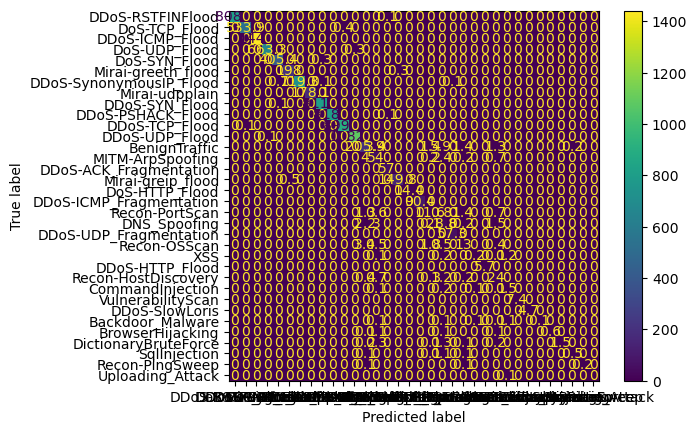

In [58]:
process_confusion_matrix(y_full_test, y_full_pred)